# DATA SCIENCE INTERN @ CODE CASA

# TASK 3 : Gender Detection and Age Detection

## <a id="2">About Dataset:</a>

The UTKFace dataset is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females.

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual. I will be using part one of the cropped variations of the images, of which there are almost 10,000. However, I will only be using the first 8000 of these images due to memory limitations.

### The dataset is available at Kaggle: https://www.kaggle.com/datasets/jangedoo/utkface-new

## <a id="2">1. Import Required Libraries:</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
from google.colab import files

# Upload the kaggle.json file that you downloaded from Kaggle
files.upload()

# Move the kaggle.json file to the appropriate location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:02<00:00, 162MB/s]
100% 331M/331M [00:02<00:00, 132MB/s]


In [6]:
!unzip /content/utkface-new.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: /content/utkface_aligned_cropped/crop_part1/34_1_2_201701042014

In [7]:
# Define the folder path in Google Drive
drive_folder_path = '/content/drive/My Drive/UTKFace/'

# Create a Path object for the folder
path = Path(drive_folder_path)

In [8]:
# loading filepath:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [9]:
# checking number of images:
print("Number of Images: ", len(filenames))
print("Checking some image names: ", filenames[:3])

Number of Images:  23708
Checking some image names:  ['26_1_3_20170104232413655.jpg.chip.jpg', '2_0_4_20161221195155711.jpg.chip.jpg', '11_1_2_20170104005111615.jpg.chip.jpg']


## <a id="2">2. Data Preprocessing:</a>

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [10]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [11]:
image_path[0:10]

['26_1_3_20170119193107971.jpg.chip.jpg',
 '45_1_3_20170119171447928.jpg.chip.jpg',
 '1_0_2_20161219161826830.jpg.chip.jpg',
 '3_1_2_20161219160306229.jpg.chip.jpg',
 '27_0_2_20170116170914365.jpg.chip.jpg',
 '28_1_0_20170117122008648.jpg.chip.jpg',
 '26_0_0_20170117171613595.jpg.chip.jpg',
 '25_0_1_20170116003121821.jpg.chip.jpg',
 '34_0_3_20170117134903926.jpg.chip.jpg',
 '38_0_2_20170104201018401.jpg.chip.jpg']

In [12]:
# converting unstructured data into structured data:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [13]:
# checking first five rows:
df.head()

,image,age,gender
0,26_1_3_20170119193107971.jpg.chip.jpg,26,1
1,45_1_3_20170119171447928.jpg.chip.jpg,45,1
2,1_0_2_20161219161826830.jpg.chip.jpg,1,0
3,3_1_2_20161219160306229.jpg.chip.jpg,3,1
4,27_0_2_20170116170914365.jpg.chip.jpg,27,0


In [14]:
# checking datatypes:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  object
 2   gender  23708 non-null  object
dtypes: object(3)
memory usage: 555.8+ KB


In [15]:
#changing data from numerical to categorical:
gender_dict = {0:"Male",1:"Female"}

In [16]:
# changing data types:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [17]:
# checking datatypes again:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23708 non-null  object 
 1   age     23708 non-null  float32
 2   gender  23708 non-null  int32  
dtypes: float32(1), int32(1), object(1)
memory usage: 370.6+ KB


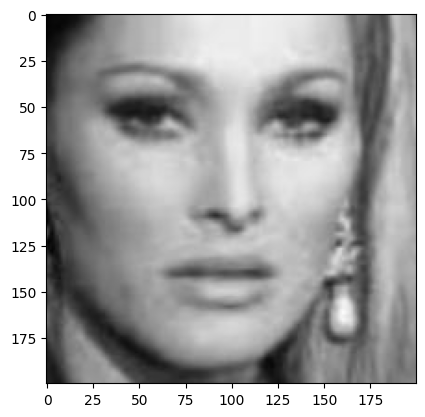

In [18]:
# check any random image:
img = Image.open("UTKFace/"+df.image[5])
plt.imshow(img)
plt.show()

<ipython-input-19-c087239766e8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


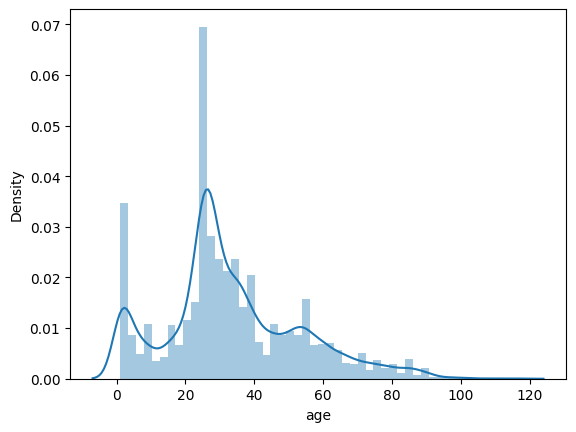

In [19]:
# checking age distribution:
sns.distplot(df.age)
plt.show()

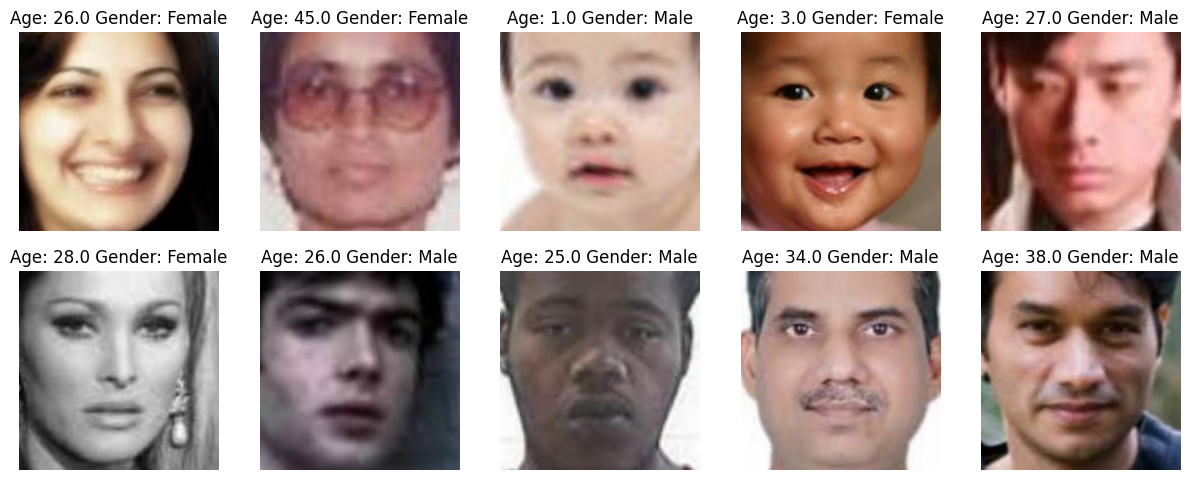

In [20]:
# let's plot some inages:
files = df.iloc[0:10]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset.
I have already shuffled all the data to ensure no biasness in the dataset.

## <a id="2">3. Train-Test-Split:</a>

In [21]:
train, test = train_test_split(df, test_size = 0.30, random_state=42)

In [22]:
# check first five rows:
train.head()

,image,age,gender
6045,86_0_0_20170111223837209.jpg.chip.jpg,86.0,0
7503,26_1_0_20170117174719206.jpg.chip.jpg,26.0,1
12843,1_1_4_20161221202018329.jpg.chip.jpg,1.0,1
14525,27_0_4_20170103235026964.jpg.chip.jpg,27.0,0
9728,26_1_1_20170113000749634.jpg.chip.jpg,26.0,1


In [23]:
# check first five rows:
test.head()

,image,age,gender
17525,1_0_2_20161219203943516.jpg.chip.jpg,1.0,0
1147,22_1_3_20170105002128188.jpg.chip.jpg,22.0,1
1190,52_0_0_20170104165813945.jpg.chip.jpg,52.0,0
9731,60_1_0_20170110184058156.jpg.chip.jpg,60.0,1
7387,2_1_0_20170109194711891.jpg.chip.jpg,2.0,1


In [24]:
# check shape of train and test data:
train.shape, test.shape#

((16595, 3), (7113, 3))

## <a id="2">4. Feature Extraction:</a>

In [25]:
# converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-25-e40c89b799d1>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [26]:
x_train.shape

(16595, 128, 128, 1)

## <a id="2">4. Normalizing Data:</a>

In [27]:
x_train = x_train/255

In [28]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [29]:
input_size = (128,128,1)

## <a id="2">5. Model Creation using CNN:</a>

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but I have implemented CNN with little Skip connections (shortcut).

In [30]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [31]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)           0         ['batch_normalization[0][0

## <a id="2">6. Model Training :</a>

In [33]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
1494/1494 [==============================] - 35s 15ms/step - loss: 13.0420 - gender_output_loss: 0.5456 - age_output_loss: 12.4965 - gender_output_accuracy: 0.7267 - age_output_accuracy: 0.0359 - val_loss: 10.2741 - val_gender_output_loss: 0.3694 - val_age_output_loss: 9.9048 - val_gender_output_accuracy: 0.8434 - val_age_output_accuracy: 0.0247
Epoch 2/20
1494/1494 [==============================] - 20s 13ms/step - loss: 9.7116 - gender_output_loss: 0.3923 - age_output_loss: 9.3192 - gender_output_accuracy: 0.8250 - age_output_accuracy: 0.0130 - val_loss: 9.5704 - val_gender_output_loss: 0.3628 - val_age_output_loss: 9.2076 - val_gender_output_accuracy: 0.8313 - val_age_output_accuracy: 0.0060
Epoch 3/20
1494/1494 [==============================] - 21s 14ms/step - loss: 8.8066 - gender_output_loss: 0.3435 - age_output_loss: 8.4631 - gender_output_accuracy: 0.8516 - age_output_accuracy: 0.0090 - val_loss: 8.0212 - val_gender_output_loss: 0.3497 - val_age_output_loss: 7.6715 

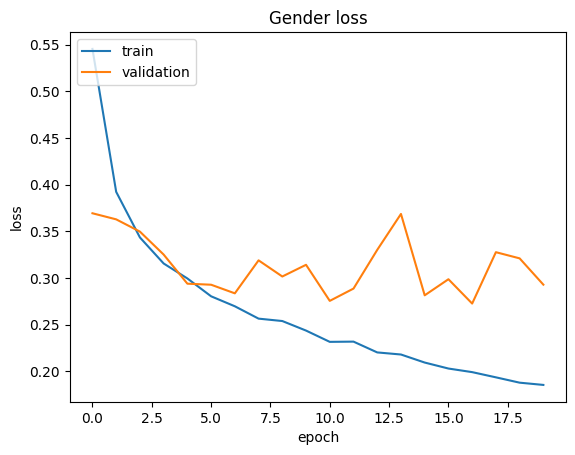

In [34]:
# loss visualization:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

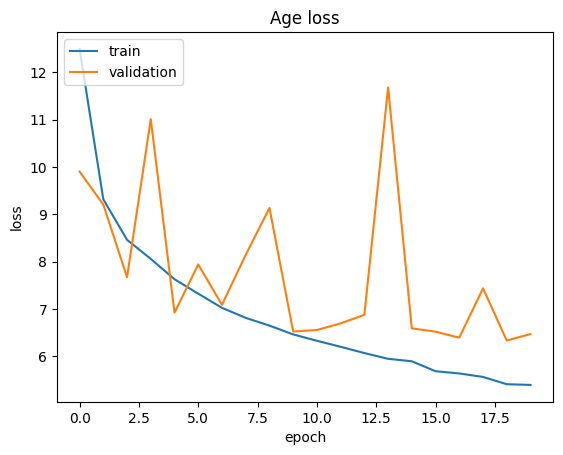

In [35]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## <a id="2">7. Model Testing:</a>

Original: Gender =  Male  Age =  26.0
1/1 [==============================] - 0s 269ms/step
Prediction: Gender =  Male  Age =  24


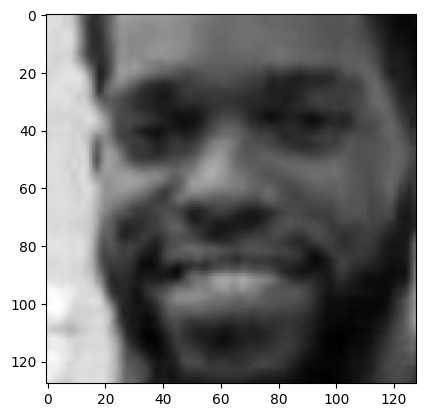

In [36]:
# Use Case_1:

index = 10
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')
plt.show()

Original: Gender =  Male  Age =  40.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Male  Age =  32


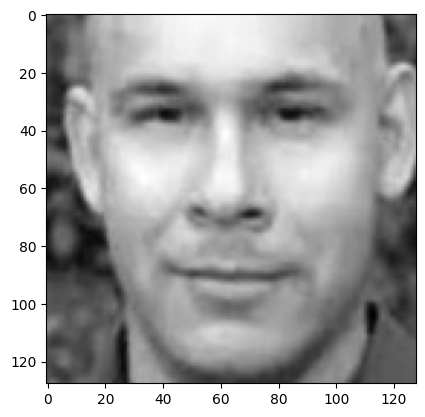

In [37]:
# Use Case_2:

index = 20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')
plt.show()

Original: Gender =  Female  Age =  26.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Female  Age =  18


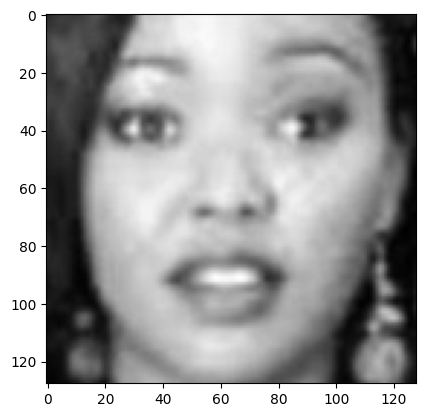

In [38]:
# Use Case_3:

index = 30
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')
plt.show()

Original: Gender =  Male  Age =  24.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Male  Age =  22


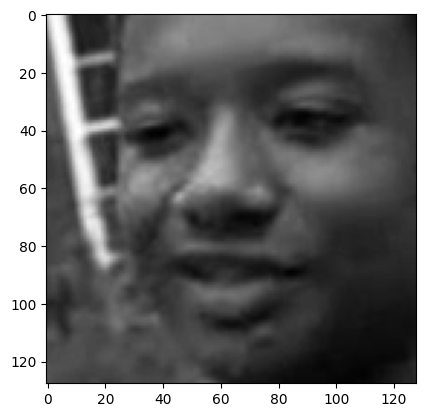

In [39]:
# Use Case_4:

index = 45
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')
plt.show()

Original: Gender =  Female  Age =  2.0
1/1 [==============================] - 0s 20ms/step
Prediction: Gender =  Female  Age =  0


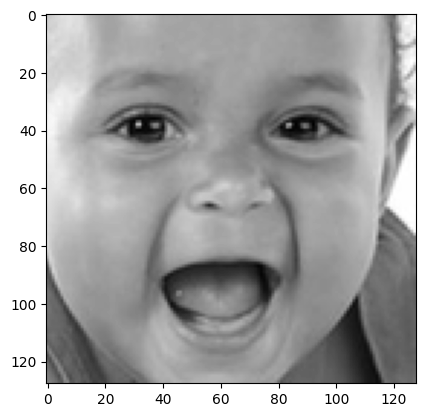

In [40]:
# Use Case_5:

index = 72
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')
plt.show()